Import necessary packages.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

Assign the data directory paths to variables for easy recall.

In [2]:
data_dir = "C:\\Users\\Team Knowhow\\Documents\\YEAR 4\\Data Science Toolbox\\DST-NN-Project\\Erin Pollard"
train_path = "C:\\Users\\Team Knowhow\\Documents\\YEAR 4\\Data Science Toolbox\\DST-NN-Project\\Erin Pollard\\Train"
test_path = "C:\\Users\\Team Knowhow\\Documents\\YEAR 4\\Data Science Toolbox\\DST-NN-Project\\Erin Pollard\\Test"


# Exploratory data Analysis

Firstly, let us explore the number of classes for the road signs.

In [3]:
number_class = len(os.listdir(train_path))
number_class

43

Let us display each of the different types of road signs in our dataset. The images below are digital example road signs, whereas our dataset is made up of photos of roadsigns so have a significantly lower resolution.

['Meta/27.png' 'Meta/0.png' 'Meta/1.png' 'Meta/10.png' 'Meta/11.png'
 'Meta/12.png' 'Meta/13.png' 'Meta/14.png' 'Meta/15.png' 'Meta/16.png'
 'Meta/17.png' 'Meta/18.png' 'Meta/19.png' 'Meta/2.png' 'Meta/20.png'
 'Meta/21.png' 'Meta/22.png' 'Meta/23.png' 'Meta/24.png' 'Meta/25.png'
 'Meta/26.png' 'Meta/28.png' 'Meta/29.png' 'Meta/3.png' 'Meta/30.png'
 'Meta/31.png' 'Meta/32.png' 'Meta/33.png' 'Meta/34.png' 'Meta/35.png'
 'Meta/36.png' 'Meta/37.png' 'Meta/38.png' 'Meta/39.png' 'Meta/4.png'
 'Meta/40.png' 'Meta/41.png' 'Meta/42.png' 'Meta/5.png' 'Meta/6.png'
 'Meta/7.png' 'Meta/8.png' 'Meta/9.png']


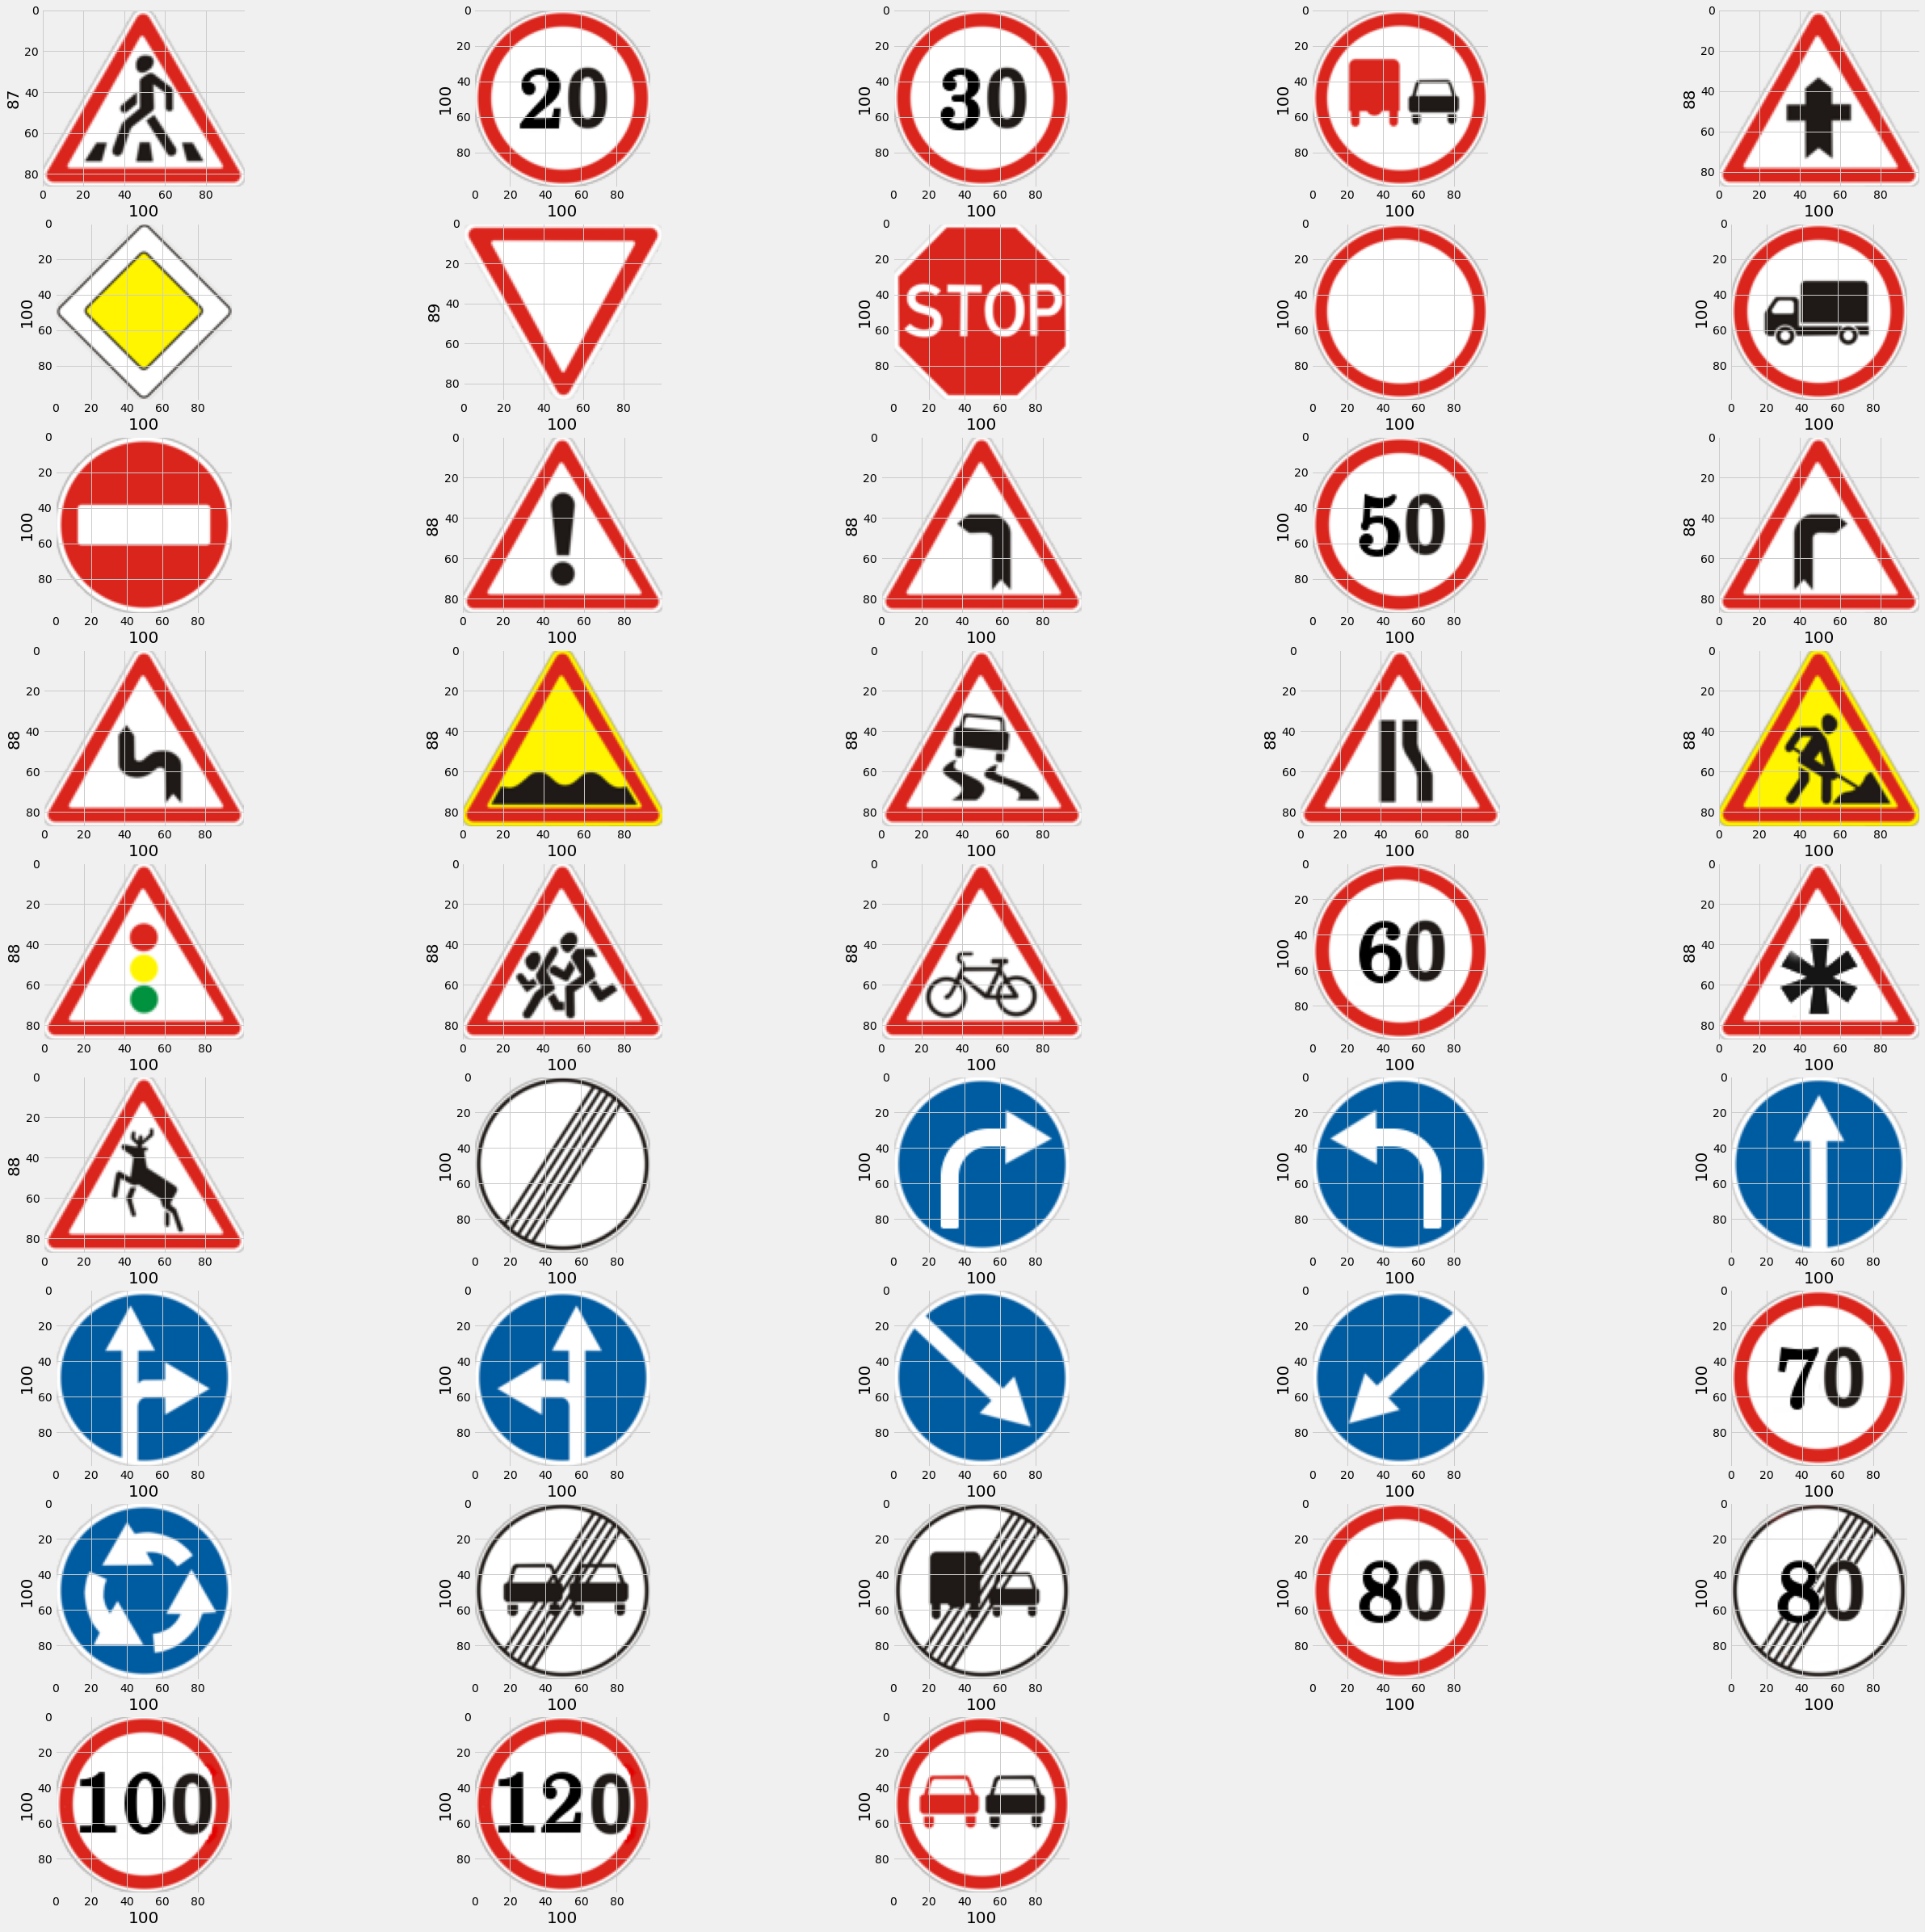

In [64]:
from matplotlib.image import imread
examples = pd.read_csv(data_dir + '/Meta.csv')
ex_imgs = examples["Path"].values
print(ex_imgs)
plt.figure(figsize=(40,40))

for i in range(int(number_class)):
  plt.subplot(9,5,int(i)+1)
  image_path = data_dir + '/' + ex_imgs[i]
  image = imread(image_path)
  plt.imshow(image)
  #plt.grid(b=None)
  plt.xlabel(image.shape[1], fontsize = 20)#width of image
  plt.ylabel(image.shape[0], fontsize = 20)#height of image

   

We then create a dictionary which matches each numerical class label with a more explanatory label. E.g., images labelled '0' are 20km/h speed limit signs.

In [65]:
classes = { 0:'20km/h speed limit',
            1:'30km/h speed limit', 
            2:'50km/h speed limit', 
            3:'60km/h speed limit', 
            4:'70km/h speed limit', 
            5:'80km/h speed limit', 
            6:'End of speed limit (80km/h)', 
            7:'100km/h speed limit', 
            8:'120km/h speed limit', 
            9:'No passing', 
            10:'No passing vehicles over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing vehicles > 3.5 tons' }

Below we store the number of each class in the training set.

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for image_folder in folders:
    train_files = os.listdir(train_path + '/' + image_folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(image_folder)])
    
# Sorting the dataset on the basis of number of images in each class
#zipped_lists = zip(train_number, class_num)
#sorted_pairs = sorted(zipped_lists)
#tuples = zip(*sorted_pairs)
#train_number, class_num = [ list(tuple) for tuple in  tuples]

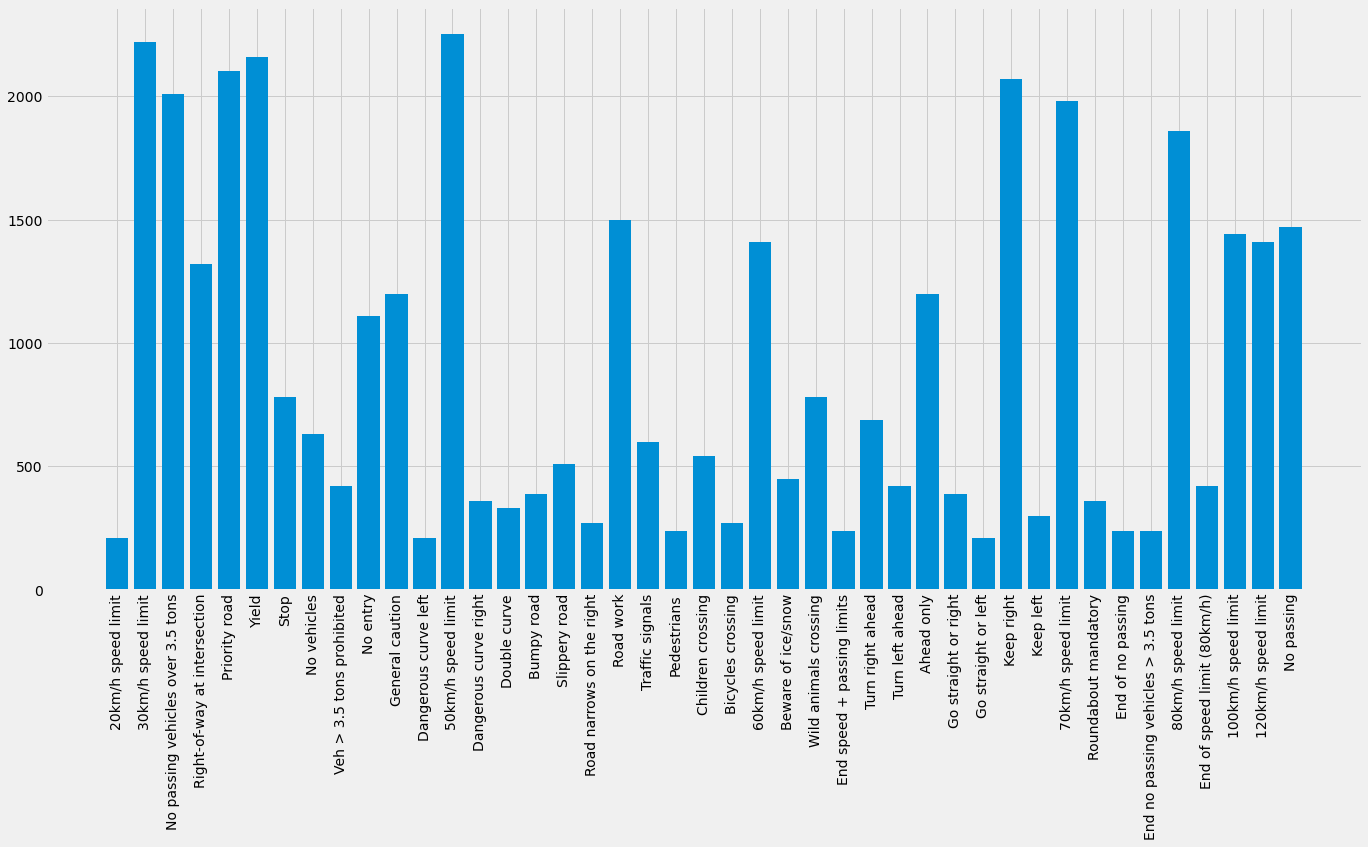

In [7]:
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

As you can see from the above plot, the classes are imbalanced. We shall deal with this during the model training by reweighting the classes to prevent favouring the majority classes.

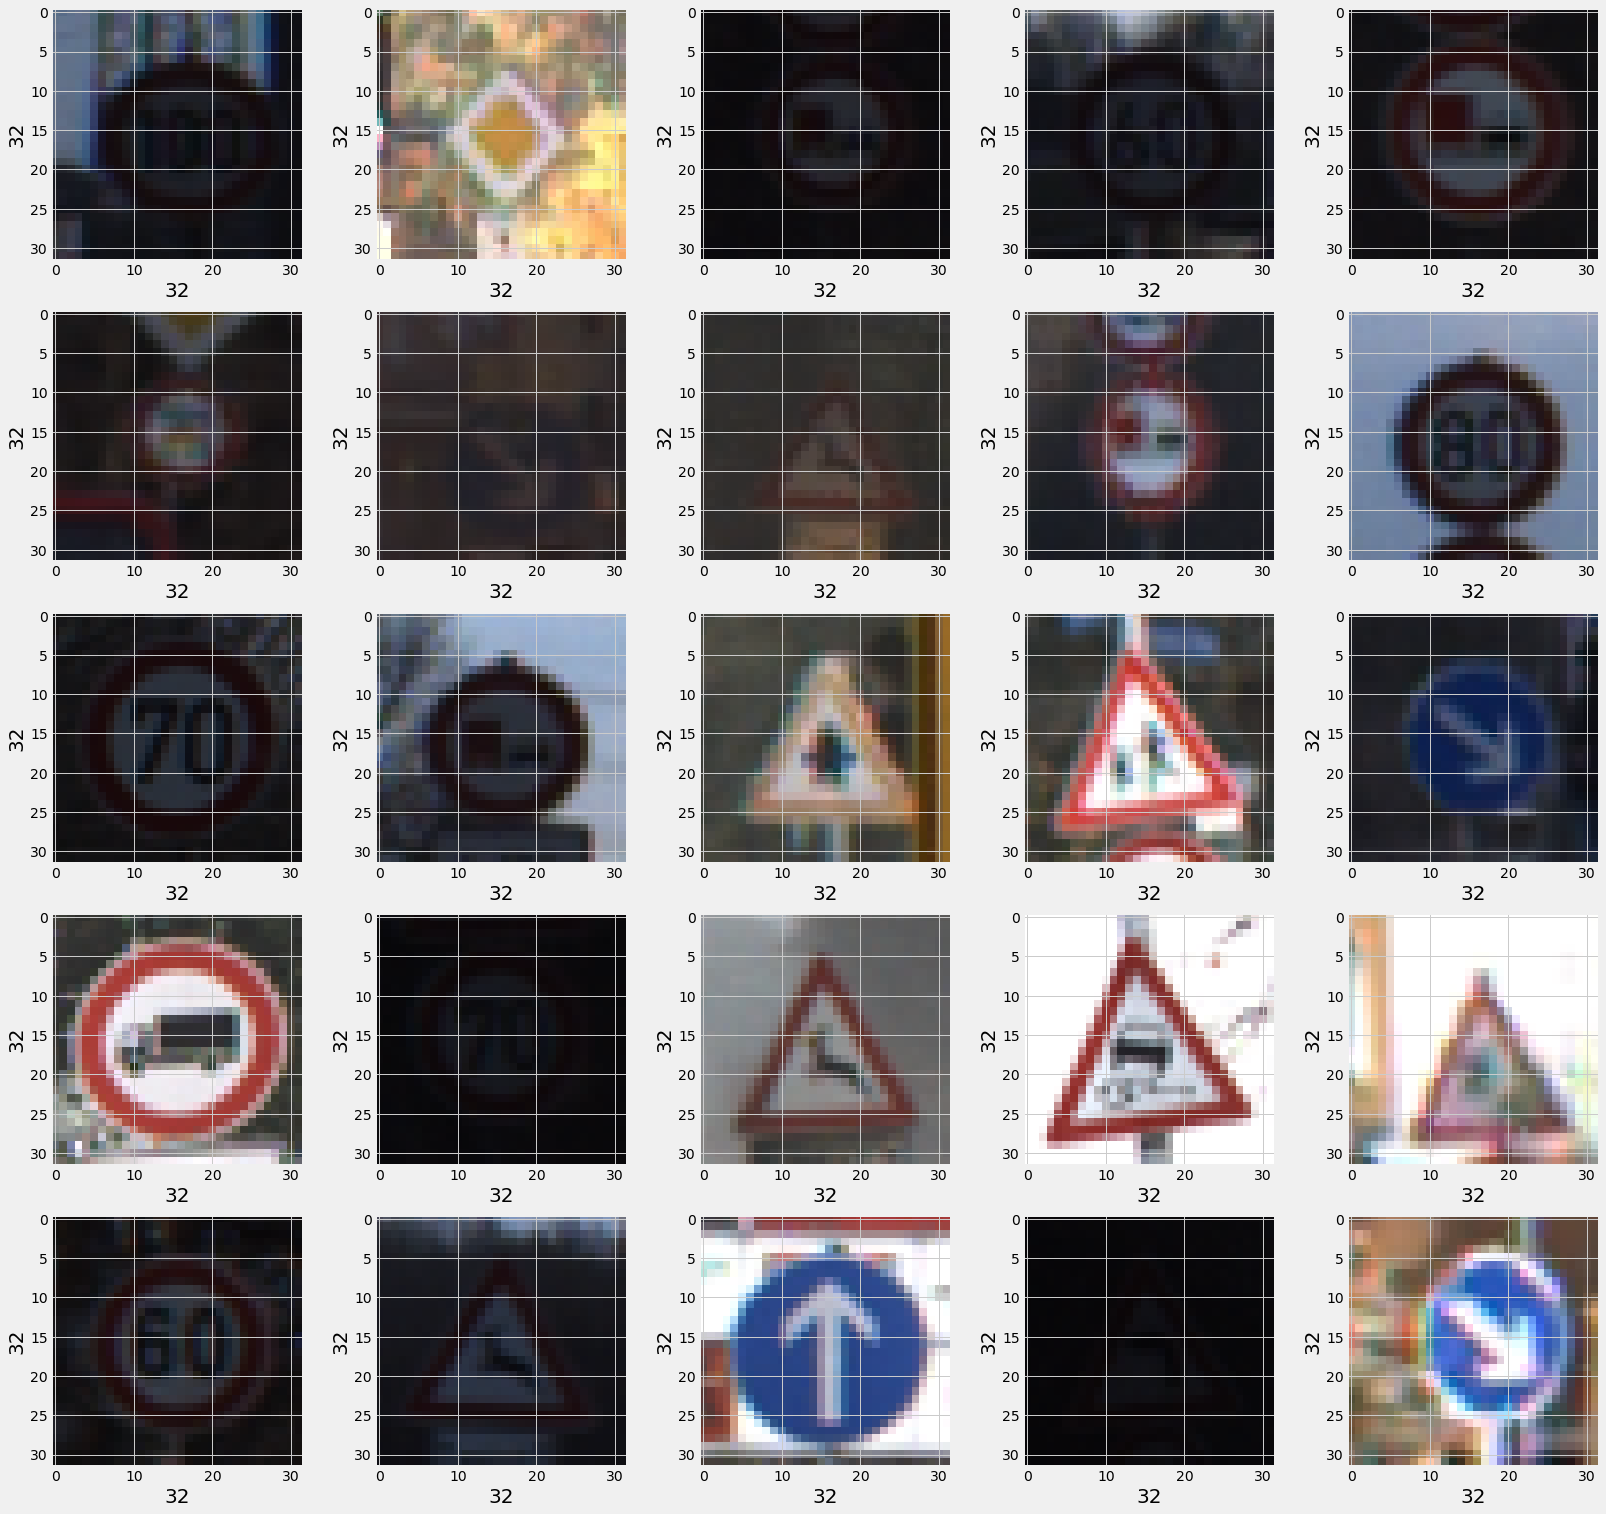

In [8]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Train.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    #plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

# Data preprocessing

## Resizing images and vectorising

Convolutional neural networks' fully connected layers demanded that all the images be in arrays of the same size, hence we must resize the images uniformly. The optimal image size used in training a convolutional neural network depends massively on the dataset [(Ramalingam, 2021).](https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05) We therefore decided to plot the image widths and heights in order to see if there were many outliers/clusters.

In [9]:
data_df = pd.read_csv("C:\\Users\\Team Knowhow\\Documents\\YEAR 4\\Data Science Toolbox\\DST-NN-Project\\Erin Pollard\\Train.csv")
data_df.drop(columns=['Roi.X1', 'Roi.Y1','Roi.X2','Roi.Y2','ClassId'])

,Width,Height,Path
0,27,26,Train/20/00020_00000_00000.png
1,28,27,Train/20/00020_00000_00001.png
2,29,26,Train/20/00020_00000_00002.png
3,28,27,Train/20/00020_00000_00003.png
4,28,26,Train/20/00020_00000_00004.png
...,...,...,...
39204,52,56,Train/42/00042_00007_00025.png
39205,56,58,Train/42/00042_00007_00026.png
39206,58,62,Train/42/00042_00007_00027.png
39207,63,69,Train/42/00042_00007_00028.png


Text(0, 0.5, 'Height')

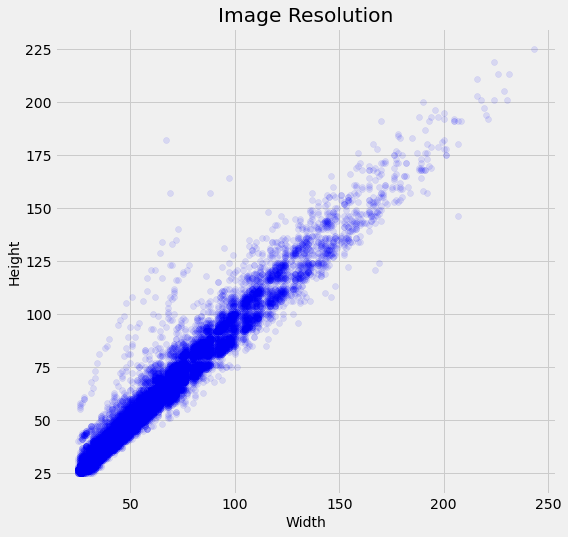

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(data_df.Width, data_df.Height, color='blue', alpha=0.1, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

There is no clear cluster in the image resolution plot, hence we decided to choose an image size smaller than the mean. This is because downscaling image sizes saves time when training and uses less memory. On the other hand, it can be harder for the CNN to learn the features required for classification.

In [11]:
av_width = data_df["Width"].mean()
av_height = data_df["Height"].mean()
print(av_width)
print(av_height)

50.83587951745773
50.328929582493814


As the average resolution is approximately 50x50 pixels, we decided to resize to 30x30. Firstly, because we wanted small represenations of the images due to training time. 

Below we resize each of the images to the set image width and height to ensure uniformity. The image is then saved to its original file. The code for resizing has been adapted from [here](https://holypython.com/how-to-batch-resize-multiple-images-in-python-via-pil-library/).

In [3]:
# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3 #as the images are in colour so represented by 3 channels (RGB)

## Vectorising the images

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In this next section, we would like to store our training images in an array, ready for input into the CNN. We access their labels by the folder name in which they are stored, this is stored separately to the image vectors. This code was adapted from this [notebook](https://www.kaggle.com/code/whitelord/german-sign-detection-dnn-solution).

In [6]:
path = train_path + '\\'+ str(1)
print(path)
class1 = os.listdir(path)

C:\Users\Team Knowhow\Documents\YEAR 4\Data Science Toolbox\DST-NN-Project\Erin Pollard\Train\1


In [15]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


In [16]:
print(image_data.shape,image_labels.shape)
# this checks that our label array and our image vector array are the same length.
# we expect our image vector array to be the number of images x 32 x 32 x 3 
# (as each pixel has 3 values, one for each colour channel RGB)

(39209, 32, 32, 3) (39209,)


In [17]:
image_data.max()

255

In [18]:
image_labels.min()

0

The above outputs confirm that the ndarray containing all the pixel values is scaled 0-255.

In [19]:
image_data

array([[[[ 66,  67,  66],
         [ 77,  79,  79],
         [ 75,  78,  79],
         ...,
         [100, 104,  99],
         [ 97, 104,  96],
         [ 89,  97,  90]],

        [[ 67,  68,  65],
         [ 75,  78,  76],
         [ 70,  74,  75],
         ...,
         [ 94, 102,  99],
         [104, 113, 109],
         [ 90, 101,  98]],

        [[ 73,  74,  67],
         [ 77,  77,  73],
         [ 72,  74,  71],
         ...,
         [ 92,  97,  97],
         [ 97, 104, 105],
         [ 95, 104, 103]],

        ...,

        [[ 83,  84,  82],
         [ 83,  86,  85],
         [ 87,  87,  86],
         ...,
         [124, 119, 109],
         [ 91,  86,  76],
         [ 85,  80,  67]],

        [[ 78,  76,  73],
         [ 82,  80,  79],
         [ 85,  84,  84],
         ...,
         [131, 125, 120],
         [102,  97,  91],
         [106, 101,  96]],

        [[ 80,  78,  75],
         [ 86,  84,  83],
         [ 81,  79,  79],
         ...,
         [136, 130, 128],
        

In [20]:
image_labels

array([ 0,  0,  0, ..., 42, 42, 42])

## Shuffling training set

Due to the way our images have been stored, (within folders with other images of the same class), we would like to randomise the order in which our images are stored. The code below shuffles the image vector array and the labels at the same time, ensuring the correct label stays inline with the corresponding image vector.

In [21]:
s=np.arange(image_data.shape[0])
np.random.seed(42)
np.random.shuffle(s)
image_data=image_data[s]
image_labels=image_labels[s]

In [22]:
image_data

array([[[[ 42,  59, 106],
         [ 39,  54,  96],
         [ 35,  51,  78],
         ...,
         [ 42,  81, 137],
         [ 49,  85, 136],
         [ 68, 112, 176]],

        [[ 47,  66, 106],
         [ 41,  58,  91],
         [ 32,  53,  88],
         ...,
         [ 23,  56,  93],
         [ 19,  49,  61],
         [ 30,  68,  84]],

        [[ 48,  71, 114],
         [ 37,  63,  95],
         [ 28,  58,  97],
         ...,
         [ 27,  57,  88],
         [ 18,  49,  61],
         [ 20,  54,  67]],

        ...,

        [[ 31,  51,  94],
         [ 38,  55,  91],
         [ 31,  46,  81],
         ...,
         [ 33,  66,  92],
         [ 41,  67, 100],
         [ 40,  70,  99]],

        [[ 43,  61,  98],
         [ 43,  59, 100],
         [ 51,  64, 107],
         ...,
         [ 44,  75, 104],
         [ 57,  82, 118],
         [ 43,  70, 103]],

        [[ 52,  78, 116],
         [ 49,  74, 123],
         [ 54,  78, 123],
         ...,
         [ 47,  82, 111],
        

In [23]:
image_labels

array([26, 15, 13, ..., 39,  1, 10])

In [24]:
np.save(data_dir +'\\32_original_train_data.npy',image_data)
np.save(data_dir +'\\32_original_train_labels.npy',image_labels)

# Repeating for test set

In [11]:
test_data=[]
test = pd.read_csv(data_dir + '/Test.csv')

test_labels = test["ClassId"].values

folder = os.listdir(test_path)
for img in folder:
  try:
    image=cv2.imread(test_path+'/'+img)
    image_from_array = Image.fromarray(image, 'RGB')
    resize_image = image_from_array.resize((IMG_HEIGHT, IMG_WIDTH))
    test_data.append(np.array(resize_image))
  except AttributeError:
    print("Error with image " + str(path+'/'+img))

            
# change list to array
test_pixels_array1=np.array(test_data)
test_labels_array1=np.array(test_labels)

Error with image C:\Users\Team Knowhow\Documents\YEAR 4\Data Science Toolbox\DST-NN-Project\Erin Pollard\Train\1/GT-final_test.csv


In [12]:
test_pixels_array1.shape

(12630, 32, 32, 3)

In [13]:
np.save(data_dir +'\\32_original_test_data.npy',test_pixels_array1)
np.save(data_dir +'\\32_original_test_labels.npy',test_labels_array1)

# Exploring Global Centering: Calculating and subtracting the mean pixel value across color channels.

A popular data preparation technique for image data is centering which involves subtracting the mean value from the pixel values [(Brownlee, 2019)](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/). We wanted to explore whether this type of data preprocessing would help make some of the images clearer/easier to distinguish features. Below we select a random image, subtract it's mean pixel value across the RGB channels, then we renormalise the pixel values between 0 and 1.

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[ 48.  59.  68.]
  [ 64.  58.  68.]
  [162. 134. 102.]
  ...
  [255. 255. 251.]
  [255. 255. 250.]
  [255. 255. 251.]]

 [[ 47.  59.  69.]
  [ 65.  59.  70.]
  [161. 132. 103.]
  ...
  [255. 255. 252.]
  [255. 255. 250.]
  [255. 255. 249.]]

 [[ 38.  48.  54.]
  [ 56.  48.  53.]
  [156. 126.  91.]
  ...
  [255. 255. 250.]
  [255. 255. 250.]
  [255. 255. 249.]]]
Means: [183.55664062 169.34667969 169.89355469]
Mins: [22. 19. 18.], Maxs: [255. 255. 255.]
Means: [0. 0. 0.]
Mins: [22. 19. 18.], Maxs: [255. 255. 255.]


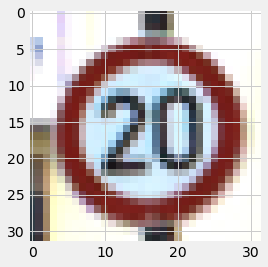

In [18]:
# example of per-channel centering (subtract mean)
from numpy import asarray
from PIL import Image
# load image
image = imread('C:/Users/Team Knowhow/Documents/YEAR 4/Data Science Toolbox/DST-NN-Project/Erin Pollard/Train/0/00000_00004_00009.png')
plt.imshow(image)
pixels = asarray(image)
# convert from integers to floats
#times by 255 as the image pixels were automatically normalised
pixels = pixels.astype('float32')
pixels = pixels*255
print(pixels)
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))
# per-channel centering of pixels
centered_pixels = pixels - means
# confirm it had the desired effect
means = centered_pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))

As subtracting the mean can cause the range of pixel values to shift to outside 0-255, we must normalise so the image can be displayed properly.

In [19]:
negative_min = abs(centered_pixels.min())
shifted_pixels = centered_pixels + negative_min

In [20]:
centered_norm_pixels = shifted_pixels/255
centered_norm_pixels.shape


(32, 32, 3)

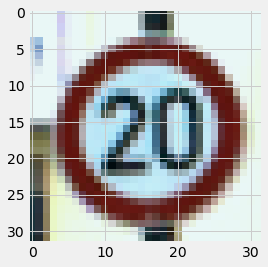

In [21]:
import matplotlib.pyplot as plt
plt.imshow(centered_norm_pixels)

The image appears slightly blue-er than before. We shall now investigate the effect on a darker image.

[[[ 39.  29.  28.]
  [ 48.  30.  28.]
  [ 59.  33.  31.]
  ...
  [ 60.  38.  36.]
  [ 55.  38.  35.]
  [ 50.  34.  28.]]

 [[ 41.  31.  30.]
  [ 54.  38.  36.]
  [ 61.  35.  32.]
  ...
  [ 55.  32.  29.]
  [ 59.  39.  34.]
  [ 55.  38.  32.]]

 [[ 47.  35.  34.]
  [ 58.  40.  39.]
  [ 56.  31.  30.]
  ...
  [ 53.  30.  27.]
  [ 57.  34.  31.]
  [ 54.  37.  34.]]

 ...

 [[ 63.  39.  35.]
  [ 56.  41.  36.]
  [ 39.  28.  27.]
  ...
  [ 85.  63.  54.]
  [ 63.  45.  39.]
  [ 55.  36.  32.]]

 [[172. 111. 105.]
  [ 75.  44.  38.]
  [ 39.  29.  24.]
  ...
  [ 86.  61.  51.]
  [ 66.  46.  40.]
  [ 55.  38.  35.]]

 [[207.  97.  83.]
  [101.  48.  35.]
  [ 38.  29.  22.]
  ...
  [ 87.  56.  44.]
  [ 68.  46.  37.]
  [ 57.  43.  39.]]]
Means: [55.45214844 38.42382812 35.57226562]
Mins: [27. 25. 22.], Maxs: [207. 175. 179.]
Means: [0. 0. 0.]
Mins: [27. 25. 22.], Maxs: [207. 175. 179.]


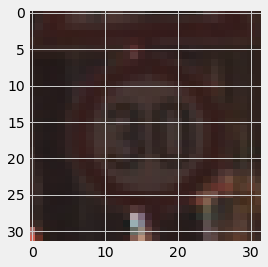

In [22]:
# load image
image = imread('C:/Users/Team Knowhow/Documents/YEAR 4/Data Science Toolbox/DST-NN-Project/Erin Pollard/Train/1/00001_00003_00010.png')
plt.imshow(image)
pixels = asarray(image)
# convert from integers to floats
#times by 255 as the image pixels were automatically normalised
pixels = pixels.astype('float32')
pixels = pixels*255
print(pixels)
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))
# per-channel centering of pixels
centered_pixels = pixels - means
# confirm it had the desired effect
means = centered_pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))


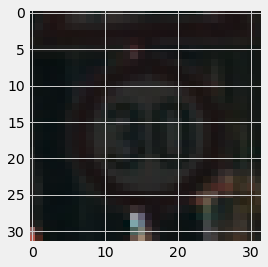

In [23]:
negative_min = abs(centered_pixels.min())
shifted_pixels = centered_pixels + negative_min

centered_norm_pixels = shifted_pixels/255
import matplotlib.pyplot as plt
#img = cv.imread(centered_norm_pixels)
plt.imshow(centered_norm_pixels)

This has actually made the image darker than before. To the human eye, this is harder to classify and this is the opposite effect of what we wanted. Instead, we tried to add the mean pixel values to each array value, and then renormalise between 0 and 1. In theory, this should brighten this image.

[[[ 39.  29.  28.]
  [ 48.  30.  28.]
  [ 59.  33.  31.]
  ...
  [ 60.  38.  36.]
  [ 55.  38.  35.]
  [ 50.  34.  28.]]

 [[ 41.  31.  30.]
  [ 54.  38.  36.]
  [ 61.  35.  32.]
  ...
  [ 55.  32.  29.]
  [ 59.  39.  34.]
  [ 55.  38.  32.]]

 [[ 47.  35.  34.]
  [ 58.  40.  39.]
  [ 56.  31.  30.]
  ...
  [ 53.  30.  27.]
  [ 57.  34.  31.]
  [ 54.  37.  34.]]

 ...

 [[ 63.  39.  35.]
  [ 56.  41.  36.]
  [ 39.  28.  27.]
  ...
  [ 85.  63.  54.]
  [ 63.  45.  39.]
  [ 55.  36.  32.]]

 [[172. 111. 105.]
  [ 75.  44.  38.]
  [ 39.  29.  24.]
  ...
  [ 86.  61.  51.]
  [ 66.  46.  40.]
  [ 55.  38.  35.]]

 [[207.  97.  83.]
  [101.  48.  35.]
  [ 38.  29.  22.]
  ...
  [ 87.  56.  44.]
  [ 68.  46.  37.]
  [ 57.  43.  39.]]]
Means: [55.45214844 38.42382812 35.57226562]
Mins: [27. 25. 22.], Maxs: [207. 175. 179.]
Means: [110.90429688  76.84765625  71.14453125]
Mins: [27. 25. 22.], Maxs: [207. 175. 179.]


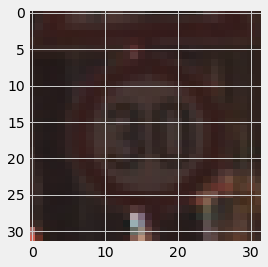

In [24]:
# load image
image = imread('C:/Users/Team Knowhow/Documents/YEAR 4/Data Science Toolbox/DST-NN-Project/Erin Pollard/Train/1/00001_00003_00010.png')
plt.imshow(image)
pixels = asarray(image)
# convert from integers to floats
#times by 255 as the image pixels were automatically normalised
pixels = pixels.astype('float32')
pixels = pixels*255
print(pixels)
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))
# per-channel centering of pixels
plusmean_pixels = pixels + means
# confirm it had the desired effect
means = plusmean_pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))

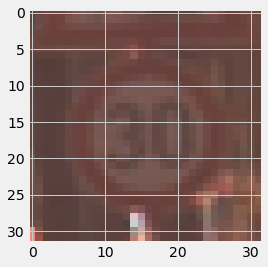

In [25]:
max_val = abs(plusmean_pixels.max())

centered_norm_pixels2 = plusmean_pixels/(max_val)
import matplotlib.pyplot as plt
#img = cv.imread(centered_norm_pixels)
plt.imshow(centered_norm_pixels2)

As we can see, this has had the desired effect. Rather than applying a blank filter to all images, we shall now apply a combination of darkening and brightening to all of the images in the training set using an if-else statement. Those that have a mean pixel value below a certain threshold shall be brightened, whereas those with a mean pixel value above a certain threshold shall be darkened to show more contrast.

In order to evaluate how bright an image is, we calculate a weighted average of the mean RGB channels:
0.21xR + 0.72xG + 0.07xB.

This was decided based on the [formula](https://en.wikipedia.org/wiki/Relative_luminance) for relative luminance.

[[[69. 70. 71.]
  [72. 73. 74.]
  [71. 72. 74.]
  ...
  [62. 64. 69.]
  [63. 63. 69.]
  [63. 62. 68.]]

 [[75. 75. 73.]
  [79. 79. 77.]
  [72. 73. 73.]
  ...
  [61. 62. 67.]
  [64. 64. 70.]
  [64. 63. 70.]]

 [[86. 85. 86.]
  [88. 87. 88.]
  [79. 80. 83.]
  ...
  [62. 63. 68.]
  [65. 65. 69.]
  [64. 63. 69.]]

 ...

 [[68. 66. 72.]
  [70. 68. 74.]
  [69. 67. 73.]
  ...
  [64. 62. 68.]
  [62. 62. 70.]
  [61. 62. 67.]]

 [[67. 66. 71.]
  [68. 67. 73.]
  [68. 67. 74.]
  ...
  [62. 61. 69.]
  [62. 62. 71.]
  [62. 62. 68.]]

 [[65. 64. 69.]
  [67. 67. 74.]
  [67. 67. 73.]
  ...
  [63. 62. 67.]
  [64. 63. 68.]
  [63. 62. 66.]]]
Means: [69.74316406 68.44238281 73.96777344]
Mins: [59. 59. 62.], Maxs: [147. 113. 107.]
69.10232421875
Brighten
Means: [0.64355584 0.63155286 0.68253847]
Mins: [0.5939895  0.58798802 0.62732208], Maxs: [1.         0.83713082 0.83494109]


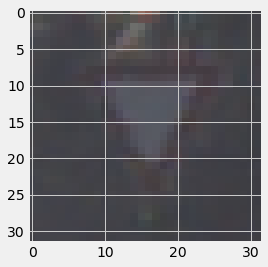

In [26]:
img = Image.open('C:/Users/Team Knowhow/Documents/YEAR 4/Data Science Toolbox/DST-NN-Project/Erin Pollard/Train/13/00013_00000_00004.png')
plt.imshow(img)
pixels = asarray(img)
pixels = pixels.astype('float32')
print(pixels)
# calculate per-channel means
means = pixels.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (pixels.min(axis=(0,1)), pixels.max(axis=(0,1))))
#calculate weighted average
weighted = means[0]*0.21 + means[1]*0.72 + means[2]*0.07
print(weighted)

if weighted >= 175: #darken
  # per-channel centering of pixels
  centered_pixels = pixels - means
  negative_min = abs(centered_pixels.min())
  shifted_pixels = centered_pixels + negative_min
  centered_norm_pixels = shifted_pixels/255
  # confirm it had the desired effect
  means = centered_norm_pixels.mean(axis=(0,1), dtype='float64')
  print('Darken')
  print('Means: %s' % means)
  print('Mins: %s, Maxs: %s' % (centered_norm_pixels.min(axis=(0,1)),centered_norm_pixels.max(axis=(0,1))))
elif weighted <= 75: #brighten
  # per-channel centering of pixels
  centered_pixels = pixels + means
  max_val = abs(centered_pixels.max())
  centered_norm_pixels = centered_pixels/(max_val)
  # confirm it had the desired effect
  means = centered_norm_pixels.mean(axis=(0,1), dtype='float64')
  print('Brighten')
  print('Means: %s' % means)
  print('Mins: %s, Maxs: %s' % (centered_norm_pixels.min(axis=(0,1)), centered_norm_pixels.max(axis=(0,1))))



Let's see if our if-else loop had the desired effect on the above image (it should have brightened it).

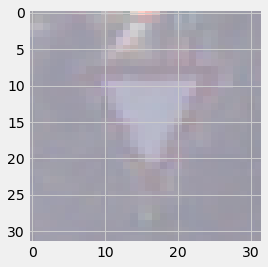

In [27]:
plt.imshow(centered_norm_pixels)

# Combining vectorisation and brightening/darkening filter

In this section I combine the vectorisation of the images step with the filter designed above. If an image is deemed as too dark, it has its mean added to each pixel value. If an image is deemed as too bright, it has its mean subtracted from each pixel.
Then the pixels are normalised to be betweeen 0 and 1. This is because although pixel values in the range 0-255 can be presented directly to neural network models in their raw format, this can result in challenges during modeling, such as in the slower than expected training of the model ([Brownlee, 2019](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)).

Instead, there can be great benefit in scaling pixel values to the range 0-1.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1 ([Brownlee, 2019](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)).

In [6]:

# Function to do brighten/darken based on weighted value
def bright_dark(pixels):
  global cnp
  pixels = pixels.astype('float32')
  means = pixels.mean(axis=(0,1), dtype='float64')
  #calculate weighted average
  weighted = means[0]*0.21 + means[1]*0.72 + means[2]*0.07
  if weighted >= 175: #darken
    centered_pixels = pixels - means
    negative_min = abs(centered_pixels.min())
    shifted_pixels = centered_pixels + negative_min
    cnp = shifted_pixels/(shifted_pixels.max())
    # confirm it had the desired effect
    means = cnp.mean(axis=(0,1), dtype='float64')
  elif weighted <= 75: #brighten
    centered_pixels = pixels + means
    max_val = abs(centered_pixels.max())
    cnp = centered_pixels/(max_val)
    # confirm it had the desired effect
    means = cnp.mean(axis=(0,1), dtype='float64')
  else:
    cnp = pixels/255
  return cnp

In [44]:
path = train_path + '/'+ str(1)
print(path)
class1 = os.listdir(path)

C:\Users\Team Knowhow\Documents\YEAR 4\Data Science Toolbox\DST-NN-Project\Erin Pollard\Train/1


In [45]:
data=[]
labels=[]

for i in range(number_class) :
    path = train_path + '/'+ str(i)
    Class=os.listdir(path)
    for img in Class:
        try:
            image=cv2.imread(path+'/'+img)
            image_from_array = Image.fromarray(image, 'RGB')
            bd = bright_dark(np.array(image_from_array))
            data.append(bd)
            labels.append(i)
        except AttributeError:
            print("Error with image " + str(path+'/'+img))
            
# change list to array
pixels_array=np.array(data)
labels_array=np.array(labels)

In [46]:
pixels_array.max()

1.0

In [47]:
pixels_array.min()

0.0

In [48]:
pixels_array.shape

(39209, 32, 32, 3)

In [49]:
labels_array

array([ 0,  0,  0, ..., 42, 42, 42])

## Shuffling training set

In [50]:
s=np.arange(pixels_array.shape[0])
np.random.seed(42)
np.random.shuffle(s)
pixels_array=pixels_array[s]
labels_array=labels_array[s]

In [51]:
pixels_array

array([[[[0.16470589, 0.23137255, 0.41568628],
         [0.15294118, 0.21176471, 0.3764706 ],
         [0.13725491, 0.2       , 0.30588236],
         ...,
         [0.16470589, 0.31764707, 0.53725493],
         [0.19215687, 0.33333334, 0.53333336],
         [0.26666668, 0.43921569, 0.6901961 ]],

        [[0.18431373, 0.25882354, 0.41568628],
         [0.16078432, 0.22745098, 0.35686275],
         [0.1254902 , 0.20784314, 0.34509805],
         ...,
         [0.09019608, 0.21960784, 0.36470589],
         [0.07450981, 0.19215687, 0.23921569],
         [0.11764706, 0.26666668, 0.32941177]],

        [[0.1882353 , 0.27843139, 0.44705883],
         [0.14509805, 0.24705882, 0.37254903],
         [0.10980392, 0.22745098, 0.38039216],
         ...,
         [0.10588235, 0.22352941, 0.34509805],
         [0.07058824, 0.19215687, 0.23921569],
         [0.07843138, 0.21176471, 0.26274511]],

        ...,

        [[0.12156863, 0.2       , 0.36862746],
         [0.14901961, 0.21568628, 0.35686275]

In [52]:
labels_array

array([26, 15, 13, ..., 39,  1, 10])

## Saving the arrays as a npy file

In [53]:
np.save(data_dir +'\\32_filter_training_data.npy',pixels_array)

In [54]:
np.save(data_dir +'\\32_filter_training_labels.npy',labels_array)

# Repeating image preprocessing for test set

In [7]:
test_data=[]
test = pd.read_csv(data_dir + '/Test.csv')

test_labels = test["ClassId"].values

folder = os.listdir(test_path)
for img in folder:
  try:
    image=cv2.imread(test_path+'/'+img)
    image_from_array = Image.fromarray(image, 'RGB')
    resize_image = image_from_array.resize((IMG_HEIGHT, IMG_WIDTH))
    bd = bright_dark(np.array(resize_image))
    test_data.append(bd)
  except AttributeError:
    print("Error with image " + str(test_path+'/'+img))



Error with image C:\Users\Team Knowhow\Documents\YEAR 4\Data Science Toolbox\DST-NN-Project\Erin Pollard\Test/GT-final_test.csv


Note, the test set is already shuffled.

In [8]:
np.save(data_dir +'\\32_filter_test_data.npy',test_data)

In [13]:
np.save(data_dir +'\\32_filter_test_label.npy',test_labels)